<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/YB_1%EC%A1%B0_%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

# 변수 설명
* title : 영화의 제목
* distributor : 배급사
* genre : 장르
* release_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
* num_staff : 스텝수
* num_actor : 주연배우수
* box_off_num : 관객수 (Target)

#**Ridge**

In [ ]:
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')

In [ ]:
train = train.drop(['title','distributor'],axis=1)
test = test.drop(['title','distributor'],axis=1)

In [ ]:
print(np.mean(train["dir_prev_bfnum"]))
print(np.mean(test["dir_prev_bfnum"]))

1050442.8914197532
891669.5160436138


In [ ]:
train["dir_prev_bfnum"].fillna(1050443,inplace = True)
test["dir_prev_bfnum"].fillna(891670,inplace = True)

In [ ]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
train['dir_prev_bfnum'] = np.log1p(train['dir_prev_bfnum'])
train['num_actor'] = np.log1p(train['num_actor'])
train['num_staff'] = np.log1p(train['num_staff'])
train['box_off_num'] = np.log1p(train['box_off_num'])

In [ ]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [ ]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas :
  ridge = Ridge(alpha = alpha)

  neg_mse_scores = cross_val_score(ridge, train[features], train[target], scoring='neg_mean_squared_error',cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 2.352 
alpha 0.1 일 때 5 folds의 평균 RMSE : 2.352 
alpha 1 일 때 5 folds의 평균 RMSE : 2.352 
alpha 10 일 때 5 folds의 평균 RMSE : 2.352 
alpha 100 일 때 5 folds의 평균 RMSE : 2.353 


In [ ]:
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

Ridge(alpha=0.1)

In [ ]:
pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission['box_off_num'] = pred
submission

,title,box_off_num
0,용서는 없다,224.527642
1,아빠가 여자를 좋아해,204.162361
2,하모니,306.855792
3,의형제,297.287761
4,평행 이론,276.408992
...,...,...
238,해에게서 소년에게,9.353395
239,울보 권투부,18.735298
240,어떤살인,166.283604
241,말하지 못한 비밀,56.902221


In [ ]:
submission.to_csv('submission_ridge.csv', index=False)

RMSE : 1986975.5343832222

#**XGBoost 1**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 0s (43.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and dir

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [ ]:
print(train.shape, test.shape)

(600, 12) (243, 11)


In [ ]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [ ]:
# 결측치 많은 데이터, 감독명, 제목 제거
train = train.drop(["dir_prev_bfnum", "director", "title"], axis = 1)
test = test.drop(["dir_prev_bfnum", "director", "title"], axis = 1)

In [ ]:
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [ ]:
# 개봉일을 바탕으로 년,월 변수 생성
train['Year'] = train['release_time'].apply(lambda x: int(x[:4]))
train['Month'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['Year'] = test['release_time'].apply(lambda x: int(x[:4]))
test['Month'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)

In [ ]:
train.head()

,distributor,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,Year,Month
0,롯데엔터테인먼트,액션,96,청소년 관람불가,0,91,2,23398,2012,11
1,(주)쇼박스,느와르,130,청소년 관람불가,2,387,3,7072501,2015,11
2,(주)쇼박스,액션,123,15세 관람가,4,343,4,6959083,2013,6
3,(주)NEW,코미디,101,전체 관람가,2,20,6,217866,2012,7
4,기타,코미디,108,15세 관람가,1,251,2,483387,2010,11


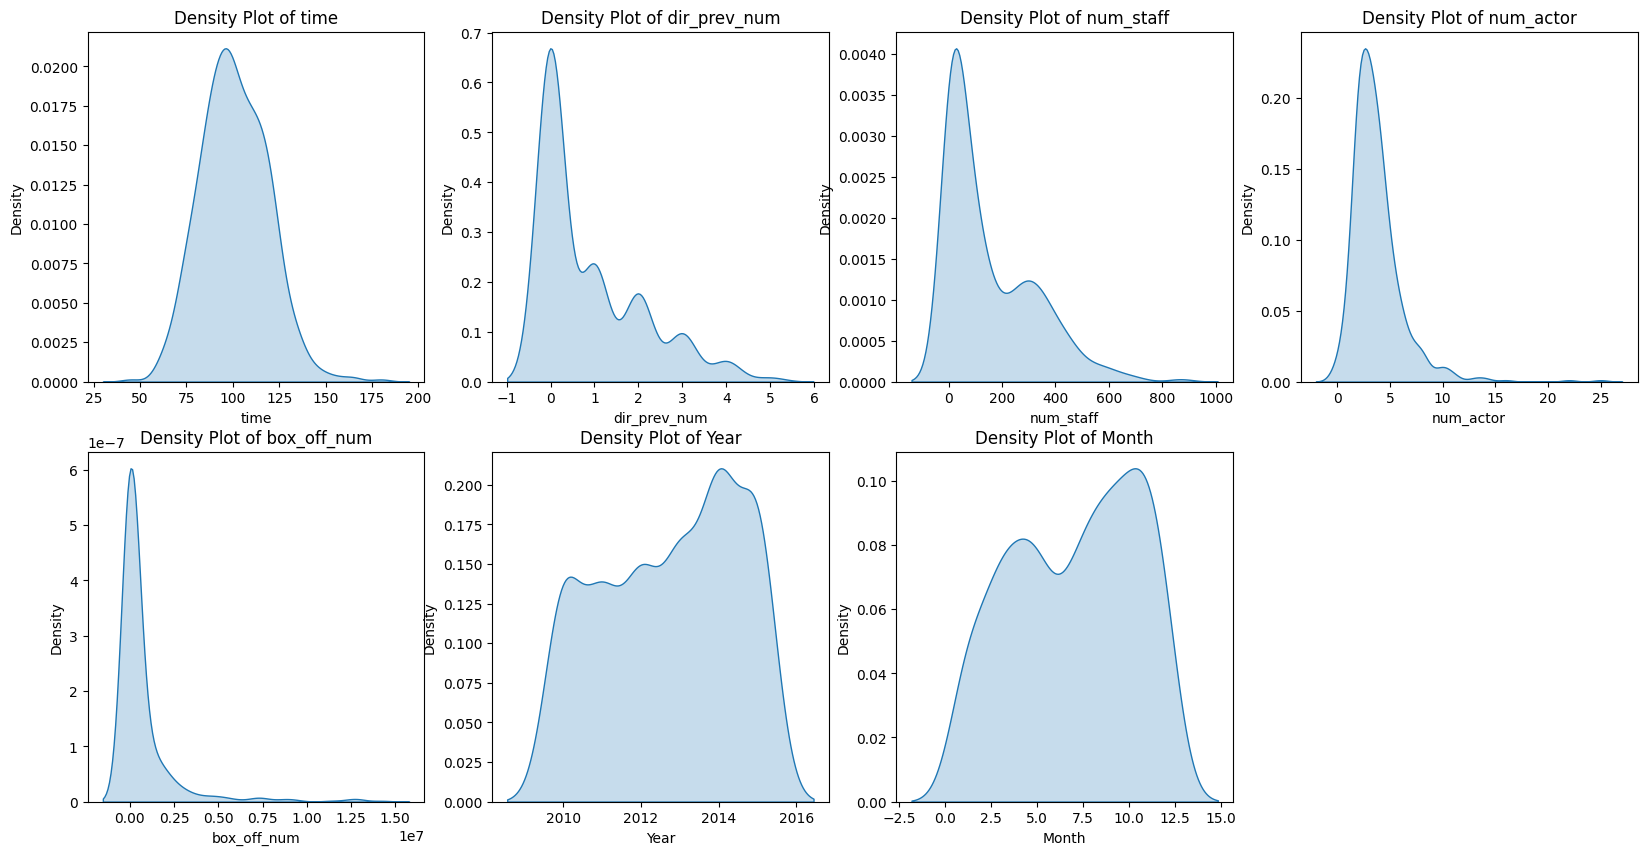

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))

list = ["time", "dir_prev_num", "num_staff", "num_actor", "box_off_num", "Year", "Month"]

for i in range(7):
  plt.subplot(2, 4, i+1)
  sns.kdeplot(train[list[i]], fill = True)
  plt.title(f"Density Plot of {list[i]}")
  plt.xlabel(f"{list[i]}")

In [ ]:
# One-hot encoding
train = pd.get_dummies(train, columns = ["distributor", "genre", "screening_rat"],
                       prefix = ["distributor", "genre", "screening_rat"])

test = pd.get_dummies(test, columns = ["distributor", "genre", "screening_rat"],
                       prefix = ["distributor", "genre", "screening_rat"])

num_staff, num_actor이 치우쳐져 있으므로 로그 스케일링 필요

In [ ]:
# Log Scaling
list = ["num_staff", "num_actor"]

for i in list:
  train[i] = np.log1p(train[i])
  test[i] = np.log1p(test[i])

In [ ]:
X_train = train.drop(["box_off_num"], axis = 1)
y_train = train["box_off_num"]

X_test = test

In [ ]:
import xgboost
from sklearn.model_selection import GridSearchCV

xgb = xgboost.XGBRegressor()

params = {
    'max_depth' : [3, 4, 5, 6],
    'n_estimators': [100, 200, 300],
    'learning_rate':[0.01, 0.1],
    'gamma': [0.5, 1, 2],
    'random_state':[99]
    }
grid_cv = GridSearchCV(xgb,param_grid = params, scoring = "neg_mean_squared_error",cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(-grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
GridSearchCV 최고 평균 정확도 수치: 2062035903798.1411
GridSearchCV 최적 하이퍼 파라미터: {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'random_state': 99}


In [ ]:
best_xgb = grid_cv.best_estimator_
xgb_pred = best_xgb.predict(X_test)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission['box_off_num'] = xgb_pred
submission

,title,box_off_num
0,용서는 없다,1.598297e+06
1,아빠가 여자를 좋아해,1.560967e+06
2,하모니,1.235658e+06
3,의형제,1.968476e+06
4,평행 이론,1.377833e+06
...,...,...
238,해에게서 소년에게,6.559964e+04
239,울보 권투부,3.721404e+04
240,어떤살인,3.345979e+05
241,말하지 못한 비밀,4.585193e+04


In [ ]:
submission.to_csv('submission_xgb.csv', index=False)

RMSE: 1286938.1840135884

#**Lasso**

In [ ]:
import pandas as pd
#train = pd.read_csv("movies_train.csv")
#test = pd.read_csv("movies_test.csv")
train = pd.read_csv('/movies_train.csv')
test = pd.read_csv('/movies_test.csv')

In [ ]:
train_df = train.copy()
test_df = test.copy()

In [ ]:
train_df.drop(['title','distributor'],axis=1,inplace=True)
test_df.drop(['title','distributor'],axis=1,inplace=True)

In [ ]:
import numpy as np

In [ ]:
##### 전처리 #####
# 이전에 작품에 참여한 경험이 없는 경우는 이전 관객수를 0으로 처리
train_df['dir_prev_bfnum'] = np.where(train_df['dir_prev_num'] == 0, 0, train_df['dir_prev_bfnum'])
test_df['dir_prev_bfnum'] = np.where(test_df['dir_prev_num'] == 0, 0, test_df['dir_prev_bfnum'])

In [ ]:
data = train_df.groupby(['director'])['box_off_num'].mean().sort_values(ascending = False)
def director_cleaning (df, data) :

    for idx, value in enumerate(data) :
        # 감독을 매칭하기 위해 df와 data에서 동일한 감독 이름이 나타나는 인덱스를 찾는다.
        temp_idx = df[df['director'] == data.index[idx]].index

        # 감독 이름이 동일한 인덱스에서 이전 관객수 값이 null이라면 감독의 평균 관객수로 결측치를 채운다.
        for df_idx in temp_idx :
            if pd.isnull(df['dir_prev_bfnum'][df_idx]) == True :
                df.at[df_idx, 'dir_prev_bfnum'] = value

    return df
train_df = director_cleaning(train_df, data)
test_df = director_cleaning(test_df, data)
# 감독별 관객수가 이전 관객수와 유사하다고 가정하고 감독별 평균 관객수를 이용하여 이전 관객수 결측치를 처리

In [ ]:
test_df['dir_prev_bfnum'] = test_df['dir_prev_bfnum'].fillna(0)
# test 데이터에서만 존재하는 감독의 경우, 'box_off_num'변수를 활용하여 결측치 처리가 불가능하므로 이전 관객수를 0으로 처리

In [ ]:
# 직관적으로 판단했을 때 전체 관람가일수록 관객수가 증가하므로
# dummies가 아닌 숫자로 인코딩
dataset = pd.concat(objs = [train_df, test_df], axis = 0)
dataset['screening_rat'] = dataset['screening_rat'].apply(lambda x : 3 \
    if x == '전체 관람가' else 2 if x == '12세 관람가' else 1 if x == '15세 관람가' \
        else 0)

In [ ]:
# 장르 인코딩
# dummies로 인코딩
dataset=pd.get_dummies(dataset, columns = ['genre'])
dataset.drop('director',axis=1,inplace=True)
dataset.drop('release_time',axis=1,inplace=True)
dataset.head()

,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디
0,96,0,0.00,0,91,2,23398.0,0,0,0,0,0,0,0,0,0,0,1,0
1,130,0,1161602.50,2,387,3,7072501.0,0,0,1,0,0,0,0,0,0,0,0,0
2,123,1,220775.25,4,343,4,6959083.0,0,0,0,0,0,0,0,0,0,0,1,0
3,101,3,23894.00,2,20,6,217866.0,0,0,0,0,0,0,0,0,0,0,0,1
4,108,1,1.00,1,251,2,483387.0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_df = dataset[:len(train)]
test_df = dataset[len(train):]

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 53328 (\N{HANGUL SYLLABLE KYU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 47704 (\N{HANGUL SYLLABLE MEN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53328 (\N{HANGUL SYLLABLE KYU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47704 (\N{HANGUL SYLLABLE MEN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args

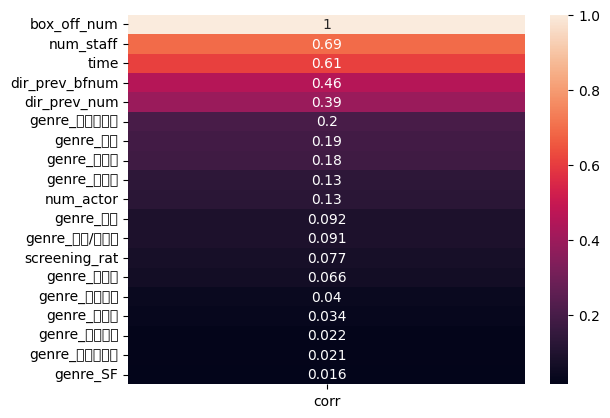

In [ ]:
# 상관관계 분석
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
corr_df = train_df.copy()

corr_df_object_cols = corr_df.dtypes[corr_df.dtypes == 'O'].index

for col in corr_df_object_cols:
    lbl = LabelEncoder()
    corr_df[col] = lbl.fit_transform(list(corr_df[col].values))

corr_df_cols = corr_df.columns[:]
corr_df_cor = abs(corr_df[corr_df_cols].corr(method = 'spearman'))
corr_df_cor = pd.DataFrame(corr_df_cor['box_off_num']).sort_values('box_off_num', ascending = False)
corr_df_cor.columns = ['corr']
sns.heatmap(corr_df_cor, annot=True)

In [ ]:
# 회귀
from sklearn.linear_model import Lasso
X_data=train_df.drop('box_off_num',axis=1,inplace=False)
y_target=train_df['box_off_num']
model=Lasso(alpha=100000)
model.fit(X_data,y_target)
lasso_preds = model.predict(test_df)
submission2 = pd.read_csv('submission.csv')
submission2['box_off_num'] = lasso_preds
submission2.to_csv('submission2.csv',index = False)

# **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gb=GradientBoostingRegressor(learning_rate=0.1,
 max_depth= 6,
 min_samples_leaf= 10,
 min_samples_split= 3,
 n_estimators= 30)
gb.fit(X_data,y_target)
preds=gb.predict(test_df)

grid_cv.fit(X_data, y_target)

In [ ]:
gb_preds = model.predict(test_df)
submission3 = pd.read_csv('submission.csv')
submission3['box_off_num'] = gb_preds
submission3.to_csv('submission3.csv',index = False)

# XGB 2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 데이터 불러오기

train=pd.read_csv("movies_train.csv")
test=pd.read_csv("movies_test.csv")
submission=pd.read_csv("submission.csv")

# 1) 데이터 특성 보기

+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


# 2) 데이터 전처리

**- 결측치 확인**

In [ ]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [ ]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [ ]:
train[train['dir_prev_bfnum'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,오빠가 돌아왔다,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [ ]:
test[test['dir_prev_bfnum'].isna()]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
5,회오리 바람,모쿠슈라,드라마,2010-02-25,95,15세 관람가,장건재,NaN,0,156,2
6,경계도시 2,시네마 달,다큐멘터리,2010-03-18,104,15세 관람가,홍형숙,NaN,0,11,2
7,이웃집 남자,(주)루믹스미디어,드라마,2010-03-18,100,청소년 관람불가,장동홍,NaN,0,117,5
8,아마존의 눈물 극장판,마운틴픽쳐스,다큐멘터리,2010-03-25,88,15세 관람가,김진만,NaN,0,76,1
9,반가운 살인자,롯데쇼핑(주)롯데엔터테인먼트,코미디,2010-04-08,107,15세 관람가,김동욱,NaN,0,255,3
...,...,...,...,...,...,...,...,...,...,...,...
235,타이밍,(주)스톰픽쳐스코리아,애니메이션,2015-12-10,100,15세 관람가,민경조,NaN,0,56,1
237,어떤이의 꿈,하준사,드라마,2015-11-26,72,12세 관람가,조성규,NaN,0,29,3
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4


In [ ]:
train=train.drop(['dir_prev_bfnum'],axis=1)
test=test.drop(['dir_prev_bfnum'],axis=1)

In [ ]:
train.isna().sum()

title            0
distributor      0
genre            0
release_time     0
time             0
screening_rat    0
director         0
dir_prev_num     0
num_staff        0
num_actor        0
box_off_num      0
dtype: int64

**- 변수 중요도에 따라 변수 정리**

In [ ]:
train.head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1,251,2,483387
5,강철대오 : 구국의 철가방,롯데엔터테인먼트,코미디,2012-10-25,113,15세 관람가,육상효,2,262,4,233211
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,0,32,5,53526
7,회사원,(주)쇼박스,액션,2012-10-11,96,청소년 관람불가,임상윤,3,342,2,1110523
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,0,138,3,868


In [ ]:
# 별로 겹치는 데이터 없어서 그냥 변수 삭제
train['director'].value_counts()

홍상수           7
장률            4
신재호           4
우민호           4
노진수           4
             ..
권오광           1
한윤선           1
박찬경           1
New Pistol    1
백운학           1
Name: director, Length: 472, dtype: int64

In [ ]:
train.groupby(['distributor'])['box_off_num'].sum().sort_values(ascending=False)[:10]

distributor
CJ 엔터테인먼트          116788093
(주)쇼박스              88053064
(주)NEW              65532145
롯데엔터테인먼트            64383745
CJ E&M Pictures      8244674
NEW                  8152133
CJ E&M 영화부문          7515928
CGV아트하우스             6590943
시네마서비스               5381059
쇼박스(주)미디어플렉스         5269646
Name: box_off_num, dtype: int64

In [ ]:
distributor_list=train['distributor'].value_counts()[:5]
distributor_list

CJ 엔터테인먼트    54
롯데엔터테인먼트     52
(주)NEW       30
(주)마운틴픽쳐스    29
(주)쇼박스       26
Name: distributor, dtype: int64

In [ ]:
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [ ]:
# 개봉일을 바탕으로 년,월 변수 생성
train['년'] = train['release_time'].apply(lambda x: int(x[:4]))
train['월'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['년'] = test['release_time'].apply(lambda x: int(x[:4]))
test['월'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)

In [ ]:
train=train.drop(['title','director'],axis=1)
test = test.drop(['title','director'],axis=1)

In [ ]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit(train.screening_rat)
train.screening_rat=encoder.transform(train.screening_rat)
test.screening_rat=encoder.transform(test.screening_rat)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit(train.distributor)
train.distributor=encoder.transform(train.distributor)
test.distributor=encoder.transform(test.distributor)

In [ ]:
train=train.drop(['genre'],axis=1)
test=test.drop(['genre'],axis=1)

In [ ]:
train.head(20)

,distributor,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,년,월,genre_rank
0,5,96,3,0,91,2,23398,2012,11,11
1,2,130,3,2,387,3,7072501,2015,11,12
2,2,123,1,4,343,4,6959083,2013,6,11
3,0,101,2,2,20,6,217866,2012,7,9
4,4,108,1,1,251,2,483387,2010,11,9
5,5,113,1,2,262,4,233211,2012,10,9
6,4,104,2,0,32,5,53526,2013,5,2
7,2,96,3,3,342,2,1110523,2012,10,11
8,4,129,2,0,3,5,4778,2014,9,1
9,4,94,1,0,138,3,868,2012,3,8


In [ ]:
test.head(20)

,distributor,time,screening_rat,dir_prev_num,num_staff,num_actor,년,월,genre_rank
0,4,125,3,2,304,3,2010,1,12
1,2,113,0,4,275,3,2010,1,5
2,3,115,0,3,419,7,2010,1,8
3,2,116,1,2,408,2,2010,2,11
4,3,110,1,1,380,1,2010,2,7
5,4,95,1,0,156,2,2010,2,8
6,4,104,1,0,11,2,2010,3,2
7,4,100,3,0,117,5,2010,3,8
8,4,88,1,0,76,1,2010,3,2
9,4,107,1,0,255,3,2010,4,9


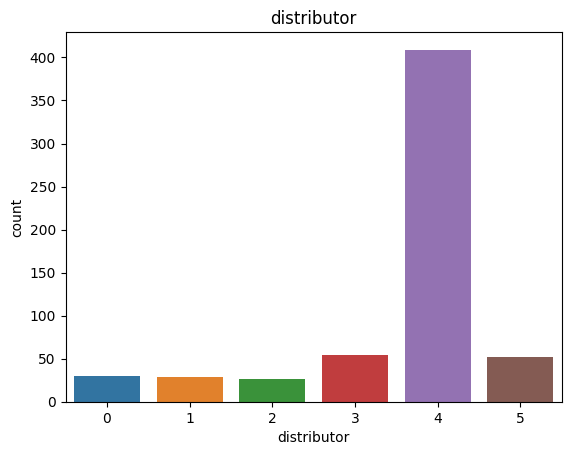

In [ ]:
import seaborn as sns

sns.countplot(x="distributor", data=train)
plt.title("distributor")
plt.show()

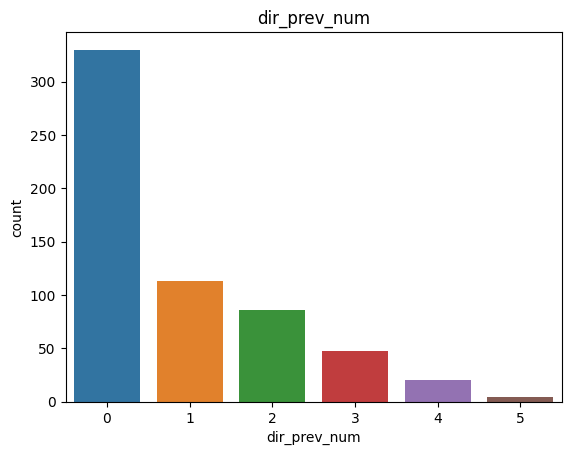

In [ ]:
sns.countplot(x='dir_prev_num',data=train)
plt.title('dir_prev_num')
plt.show()

-> 치우쳐져 있는 데이터들이 보이므로 스케일링 작업이 필요할 듯

# 최종 모델 적합 - XGBoost

In [ ]:
X_train=train.drop('box_off_num', axis=1)
y_train=train['box_off_num']

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음.
def get_scaled_data(method='None',p_degree=None,input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from xgboost import XGBRegressor

params = {'n_estimators': [500, 700],
          'max_depth':[5,7,9],
          'min_child_weight':[1,3,5],
          'learning_rate':[0.03, 0.05,0.1],
          'colsample_bytree':[0.5,0.75,1],
          'subsample':[0.3,0.5,0.8]}
xgb = XGBRegressor()
gridcv = GridSearchCV(xgb, param_grid=params,scoring='neg_mean_squared_error',cv=5)
gridcv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ',gridcv.best_params_)
print('최고 예측 정확도: ',gridcv.best_score_)

In [ ]:
# submission17 - 결과: 1189666.2951620447(최저)
X_train_scaled = get_scaled_data(method='Log',p_degree=None,input_data=X_train)
X_test = get_scaled_data(method='Log',p_degree=None,input_data=test)
model = XGBRegressor(colsample_bytree= 0.75, learning_rate= 0.05, max_depth= 7, min_child_weight= 1, n_estimators= 500)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test)

# 제출

In [ ]:
submission['box_off_num'] = pred
submission

,title,box_off_num
0,용서는 없다,3.465393e+06
1,아빠가 여자를 좋아해,1.686399e+06
2,하모니,1.136040e+06
3,의형제,2.403626e+06
4,평행 이론,8.689008e+05
...,...,...
238,해에게서 소년에게,3.072464e+05
239,울보 권투부,3.781069e+05
240,어떤살인,-1.939628e+05
241,말하지 못한 비밀,8.519977e+04


In [ ]:
submission.to_csv('submission17.csv', index=False)

결과: 1189666.2951620447(최저)